In [1]:
#Kütüphanelerin Yüklenmesi
import pandas as pd
import numpy as np
import os
import cv2

from metods import *
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
#Genel Değişkenlerin Belirlenmesi
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

models_folder = "models\\" #model klasörü oluşturuluyor

modelName = models_folder + "LungIdentifierModelVGG16Testing2.h5" #Model ismi

#Dosya yolları
healty_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty\\"
healty_mask_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty Mask 5x5\\"
healty_segmented_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty Segmented 5x5\\"

pneu_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax\\"
pneu_mask_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax Mask 5x5\\"
pneu_segmented_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax Segmented 5x5\\"

In [3]:
#Veri seti yüklenme aşaması

#Eğitim verisi için dosya isimlerini klasörlerden listeye aktarıyoruz.
healty_segmented_images = os.listdir(healty_segmented_path)
pneu_segmented_images = os.listdir(pneu_segmented_path)

#Veriyi daha hızlı yazabilmek için ön tanımlı X ve Y değişkenlerimizi oluşturuyoruz.
X_train = np.zeros((len(healty_segmented_images) + len(pneu_segmented_images), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y_train = np.zeros((len(healty_segmented_images) + len(pneu_segmented_images)), dtype=np.bool)


#Sağlıklı akciğer segmentlerini yüklüyoruz.
for i, img_id in enumerate(healty_segmented_images):
    file_name = healty_segmented_path + img_id

    img = readImages(file_name, is_gray=0)
    
    X_train[i] = img
    Y_train[i] = 0

#Sağlıklı veri miktarımız az olduğu için aynalama taktiği ile sağlıklı verilerimizi iki katına çıkarıyoruz.
X_train2 = np.flip(X_train, axis=2)
X_train = np.append(X_train, X_train2, axis=0)
Y_train = np.append(Y_train, Y_train, axis=0)

#Pnömotoraks akciğer segmentlerini yüklüyoruz.
for i, img_id in enumerate(pneu_segmented_images):
    file_name = pneu_segmented_path + img_id
    
    img = readImages(file_name, is_gray=0)
    
    X_train[len(healty_segmented_images) + i] = img
    Y_train[len(healty_segmented_images) + i] = 1

#X_train verimizi VGG16 modelimiz için uygun hale getiriyoruz. (3 Kanallı ve 4 boyutlu hale getiriyoruz)
X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
X_train = X_train.reshape(-1, 128, 128, 3)

#Kategorik eğitim yapacağımız için Y verilerimizi kategorik veriye çeviriyoruz.
Y_train = to_categorical(Y_train)

#Veri yükleme işleminden sonra işe yaramayan ve bellekte boş veri kaplamamasını istediğimiz değişkenleri hafızadan siliyoruz.
X_train2 = None
healty_segmented_images = None
pneu_segmented_images = None

print(X_train.shape)
print(Y_train.shape)

(39852, 128, 128, 3)
(39852, 2)


In [4]:
#Verimizi eğitim ve test olmak üzere 2 parçaya bölüyoruz.
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=8)

print("Train Data: ", X_train.shape)
print("Test Data: ", X_test.shape)

Train Data:  (31881, 128, 128, 3)
Test Data:  (7971, 128, 128, 3)


In [5]:
from tensorflow.keras.applications import VGG16

#VGG16 Modelimizin giriş katmanını oluşturuyoruz.
input_layer=layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

#VGG16 Modelimizi ImageNet ağırlıkları ile yüklüyoruz.
model_VGG16=VGG16(weights='imagenet', input_tensor=input_layer, include_top=False)

#VGG16 Modelinin çıkış katmanını alıyoruz.
last_layer=model_VGG16.output 

#2 sınıftan oluşan özel çıkış katmanımızı oluşturuyoruz.
flatten=layers.Flatten()(last_layer) 
output_layer=layers.Dense(2, activation='softmax')(flatten)

model=models.Model(inputs=input_layer, outputs=output_layer)
#Yeni bir model oluşturup giriş ve çıkış katmanlarını kendi katmanlarımız ile değiştiriyoruz.

#Çıkış katmanı haricindeki tüm katmanların eğitimini kapatıyoruz.
for layer in model.layers[:-1]:
    layer.trainable=False

model_EfficientNetB7 = None
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Epoch 1/40
997/997 [==============================] - 60s 44ms/step - loss: 0.2054 - accuracy: 0.9099 - val_loss: 0.1368 - val_accuracy: 0.9388

Epoch 00001: val_accuracy improved from -inf to 0.93878, saving model to models\LungIdentifierModelVGG16Testing2.h5
Epoch 2/40
997/997 [==============================] - 26s 26ms/step - loss: 0.1308 - accuracy: 0.9466 - val_loss: 0.1363 - val_accuracy: 0.9420

Epoch 00002: val_accuracy improved from 0.93878 to 0.94204, saving model to models\LungIdentifierModelVGG16Testing2.h5
Epoch 3/40
997/997 [==============================] - 26s 26ms/step - loss: 0.1257 - accuracy: 0.9504 - val_loss: 0.1125 - val_accuracy: 0.9522

Epoch 00003: val_accuracy improved from 0.94204 to 0.95220, saving model to models\LungIdentifierModelVGG16Testing2.h5
Epoch 4/40
997/997 [==============================] - 26s 26ms/step - loss: 0.1045 - accuracy: 0.9585 - val_loss: 0.1154 - val_accuracy: 0.9557

Epoch 00004: val_accuracy improved from 0.95220 to 0.95571, saving

<Figure size 432x288 with 0 Axes>

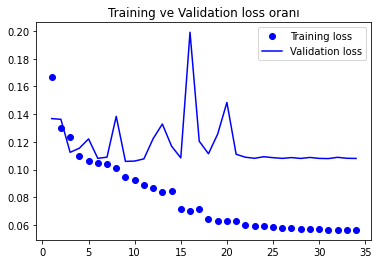

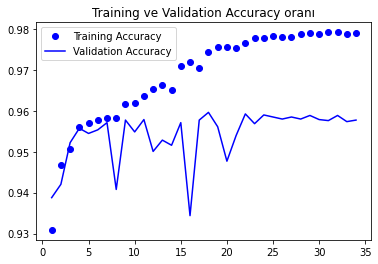

<Figure size 432x288 with 0 Axes>

In [6]:
#Modelimizi derleyip checkpointlerini belirliyoruz.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

earlystopper = EarlyStopping(patience=25, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
checkpoint = ModelCheckpoint(modelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, learning_rate_reduction, earlystopper]

#Eğitimi başlatıyoruz.
history = model.fit(X_train/255.0, Y_train, validation_data=(X_test/255.0, Y_test), batch_size=32, epochs=40, callbacks=callbacks_list, shuffle=True)

#Eğitim sonuçlarını grafiğe döküyoruz.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training ve Validation loss oranı')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training ve Validation Accuracy oranı')
plt.legend()
plt.figure()

In [7]:
#Test veri sonuçlarını pandas ile dataframe haline getiriyoruz.
df_test = pd.DataFrame()
Y_test_normal = np.argmax(Y_test, axis=-1)

print(Y_test_normal.shape)

df_test['type'] = Y_test_normal
df_test = df_test.reset_index(drop=True)
df_test.head(10)

(7971,)


,type
0,0
1,0
2,1
3,0
4,0
5,0
6,0
7,0
8,1
9,0


In [8]:
#En iyi modeli yükleyerek tahmin işlemini gerçekleştiriyoruz.
model = load_model(modelName)
preds = np.argmax(model.predict(X_test/255.0), axis=-1)

#Tahmin sonuçlarını gerçek sonuçlar ile karşılaştırıyoruz.
df_test['preds'] = np.round(preds)
df_test['preds'] = df_test['preds'].apply(np.int)

wrongs_df = df_test.loc[df_test['type'] != df_test['preds']]

print(f"Doğruluk oranı %{100 - (len(wrongs_df) * 100 / len(df_test))}")

df_test.head(10)

Doğruluk oranı %95.96035629155689


,type,preds
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,1,1
9,0,0


Accuracy :  0.9596035629155689
Sensitivity :  0.9808748343116834
Specificity :  0.9178438661710037


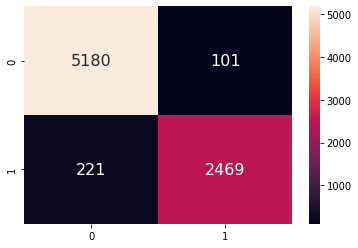

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

#Modelimizin metriklerini hesaplıyoruz.
cm1 = confusion_matrix(df_test[['type']], df_test['preds'])
sn.heatmap(cm1, annot=True, annot_kws={"size": 16}, fmt="d")

total1=sum(sum(cm1))

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)